In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.evaluation.metrics import aggregate_scores, calculate_scores
from src.data.data_loading import load_config
from src.data.code_processor import parse_code

In [10]:
# Set plot style
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'
# Set color palette
#sns.set_palette('Paired')
sns.set_context('paper')

# Set working directory

In [4]:
# set working directory to project root - EXECUTE ONLY ONCE or RESTART KERNEL
os.chdir('..')
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\cadenza-playwright-llm'

# Load data + config

In [5]:
config = load_config(config_path='config/config.yaml')

# Scoring
Metrics implemented and used in this project (see `src/evaluation/metrics.py`):
* **Weighted BLEU** $ \in [0.0, 1.0] $: The BLEU score proposed by [Papineni et al. (2002)](https://aclanthology.org/P02-1040.pdf) [1], [2] is a metric that measures the similarity between two sequences of text. The weighted BLEU score is a variant implementd in this project that uses a weighted average of the BLEU scores of the precondition part and the actual generated additional part in teh generated test script. The weights are defined in the configuration file `config/config.yaml`.
* **Success Rate** $ \in [0.0, 1.0] $: The success rate is the proportion of generated test scripts that run successfully, no matter if they are semantically correct or not.
* **Levenshtein Distance** $ d(s, t) \in \mathbb{N} $: The Levenshtein distance between strings $ s $ and $ t $ is an integer that measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change $ s $ into $ t $.

**Manual Evaluation**
First we are going to test the core functionality of the scoring functions by defining some example test cases and running the scoring functions on them.

In [6]:
# Define example test cases
test_cases = [
    {
        'test_case': '1',
        'test_step': '2',
        'generated_code': parse_code(config['paths']['prediction_dir']+'/1_2.spec.ts'),
        'validation_code': parse_code(config['dataloading']['test_script_dir']+'/1_2.spec.ts'),
        'precondition_code': parse_code(config['dataloading']['test_script_dir']+'/1_1.spec.ts')
    },
    {
        'test_case': '2',
        'test_step': '2',
        'generated_code': parse_code(config['paths']['prediction_dir']+'/2_2.spec.ts'),
        'validation_code': parse_code(config['dataloading']['test_script_dir']+'/2_2.spec.ts'),
        'precondition_code': parse_code(config['dataloading']['test_script_dir']+'/2_1.spec.ts')
    }
]

In [9]:
test_cases[1]['generated_code']

"import { test, expect } from '@playwright/test';\nimport { writeFileSync } from 'fs';\n\ntest('test', async ({ page }) => {\n  await page.goto('http://localhost:8080/cadenza/');\n  await page.getByRole('link', { name: 'Anmelden' }).click();\n  await page.getByLabel('Benutzername *').click();\n  await page.getByLabel('Benutzername *').fill('Admin');\n  await page.getByRole('button', { name: 'Anmelden' }).click();\n  await page.getByTestId('create-workbook-button').click();\n});\n"

In [30]:
# Run scoring for test cases
scores = calculate_scores(test_cases, config)
scores

2024-07-21 16:46:48 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 1_2...
2024-07-21 16:46:48 [src.evaluation.metrics:239] [DEBUG] >>>> Running Playwright test for 1_2.spec.ts...
2024-07-21 16:46:53 [src.evaluation.metrics:247] [DEBUG] >>>> Test 1_2.spec.ts passed. Score: 1
2024-07-21 16:46:54 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 2_2...
2024-07-21 16:46:54 [src.evaluation.metrics:239] [DEBUG] >>>> Running Playwright test for 2_2.spec.ts...
2024-07-21 16:47:58 [src.evaluation.metrics:250] [DEBUG] >>>> Test 2_2.spec.ts failed. Score: 0


{'weighted bleu': [0.5006969523919225, 0.3988451029814817],
 'success rate': [1, 0],
 'levenshtein distance': [0.09230769230769231, 0.2632398753894081],
 'similarity': [0, 0]}

In [31]:
# Aggregate scores
agg_scores = aggregate_scores(scores)
agg_scores

2024-07-21 16:47:58 [src.evaluation.metrics:59] [WARNING] >>>> Unknown metric: similarity. Skipping...


{'weighted bleu': 0.4497710276867021,
 'success rate': 0.5,
 'levenshtein distance': 0.1777737838485502,
 'similarity': None}

**Automated Evaluation**
For simplicity an evaluation test script is implemented in `scripts/evaluation.py` that runs the scoring functions on all test cases available in the prediction directory defined in the configuration file `config/config.yaml`. The evaluation results are also automatically saved as a pickle file in the scoring results directory defined in the configuration file `config/config.yaml`.

In [32]:
# Run complete automated evaluation script
!python scripts/evaluation.py --config=config/config.yaml

2024-07-21 16:48:05 [__main__:22] [INFO] >>>> Calculating scores...
2024-07-21 16:48:05 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 1_2...
2024-07-21 16:48:05 [src.evaluation.metrics:239] [DEBUG] >>>> Running Playwright test for 1_2.spec.ts...

Running 1 test using 1 worker

  ok 1 1_2.spec.ts:4:5 â€º test (3.0s)

  1 passed (4.1s)
2024-07-21 16:48:11 [src.evaluation.metrics:247] [DEBUG] >>>> Test 1_2.spec.ts passed. Score: 1
2024-07-21 16:48:11 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 2_2...
2024-07-21 16:48:11 [src.evaluation.metrics:239] [DEBUG] >>>> Running Playwright test for 2_2.spec.ts...

Running 1 test using 1 worker

  x  1 2_2.spec.ts:4:5 â€º test (30.0s)
  x  2 2_2.spec.ts:4:5 â€º test (retry #1) (30.0s)


  1) 2_2.spec.ts:4:5 â€º test â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”

It is also possible to evaluate the test cases inside the notebook by using the evaluate_test_cases() function without running the whole script but directly calling the main function of the script:

In [35]:
%%time
# Run complete automated evaluation inside notebook
from scripts.evaluation import evaluate_test_cases

dir = "pred_test_script_template_2_html_concat_mode_all_max_attr_length_50_pretrained"
config = load_config(config_path='config/config.yaml')
config['paths']['prediction_dir'] = "data/prediction/" + dir + "/"

results = evaluate_test_cases(config)
results

2024-07-21 17:01:51 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:01:51 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:01:51 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 17:01:51 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:01:53 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:01:53 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:01:53 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 17:01:53 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:01:55 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:01:55 [src.e

,file_id,test_case,test_step,prediction_dir,weighted bleu,success rate,levenshtein distance,similarity
0,10_1,10,1,data/prediction/pred_test_script_template_2_ht...,0.000000,0,0.777403,0
1,10_2,10,2,data/prediction/pred_test_script_template_2_ht...,0.000000,0,0.800898,0
2,10_3,10,3,data/prediction/pred_test_script_template_2_ht...,0.415113,0,0.218534,0
3,10_4,10,4,data/prediction/pred_test_script_template_2_ht...,0.375325,0,0.216749,0
4,10_5,10,5,data/prediction/pred_test_script_template_2_ht...,0.333697,0,0.244521,0
...,...,...,...,...,...,...,...,...
95,9_2,9,2,data/prediction/pred_test_script_template_2_ht...,0.000000,0,0.800898,0
96,9_3,9,3,data/prediction/pred_test_script_template_2_ht...,0.415113,0,0.224966,0
97,9_4,9,4,data/prediction/pred_test_script_template_2_ht...,0.434953,0,0.194514,0
98,9_5,9,5,data/prediction/pred_test_script_template_2_ht...,0.001873,0,0.750869,0


# Run Scoring on all Different Predictions
We generated different predictions using different input configurations. Now we want to evaluate all of them and compare the results.

In [36]:
# Adjust file names from pred.ts to spec.ts
def rename_files_in_directory(directory: str):
    # List all files in the directory
    for file_name in os.listdir(directory):
        # Check if the file name ends with '.pred.ts'
        if file_name.endswith('.pred.ts'):
            # Create the new file name
            new_file_name = file_name.replace('.pred.ts', '.spec.ts')
            # Create the full paths to the old and new file names
            old_file_path = os.path.join(directory, file_name)
            new_file_path = os.path.join(directory, new_file_name)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{old_file_path}' to '{new_file_path}'")

In [39]:
%%time
# Go through prediction directory and run the renaming function and evaluation function on each directory
results = []
for dir in tqdm(os.listdir("data/prediction/")):
    if dir == '.gitkeep':
        continue
    print('\n'+'='*80+'\n')
    print(f"Processing directory '{dir}'...\n")
    rename_files_in_directory("data/prediction/" + dir)
    config['paths']['prediction_dir'] = "data/prediction/" + dir + "/"
    result = evaluate_test_cases(config)
    results.append(result)

# merge
results = pd.concat(results).reset_index(drop=True)
results.to_pickle(config['paths']['scores_dir']+'eval_scores_all.pkl')

  0%|          | 0/25 [00:00<?, ?it/s]



Processing directory 'pred_test_script'...

2024-07-21 17:13:27 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:13:27 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 1_2...
2024-07-21 17:13:27 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 1_2.spec.ts...
2024-07-21 17:13:33 [src.evaluation.metrics:246] [DEBUG] >>>> Test 1_2.spec.ts passed. Score: 1
2024-07-21 17:13:33 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 2_2...
2024-07-21 17:13:33 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 2_2.spec.ts...
2024-07-21 17:14:38 [src.evaluation.metrics:249] [DEBUG] >>>> Test 2_2.spec.ts failed. Score: 0
2024-07-21 17:14:38 [scripts.evaluation:46] [INFO] >>>> Scores calculated.
2024-07-21 17:14:38 [scripts.evaluation:49] [INFO] >>>> Aggregating...
2024-07-21 17:14:38 [src.evaluation.metrics:59] [WARNING] >>>> Unknown metric: similarity. Skipping...
2024-07-21 17:14:38 [sc

  8%|▊         | 2/25 [01:10<13:33, 35.37s/it]



Processing directory 'pred_test_script_finetuned_T1_sc+_html+_single'...

2024-07-21 17:14:38 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:14:38 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:14:38 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:14:40 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:14:40 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:14:40 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:14:42 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:14:42 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:14:42 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:14:44 [src.eva

 12%|█▏        | 3/25 [05:47<49:46, 135.75s/it]



Processing directory 'pred_test_script_finetuned_T1_sc+_html+_single_test_set'...

2024-07-21 17:19:14 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:19:14 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_1...
2024-07-21 17:19:14 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_1.spec.ts...
2024-07-21 17:19:16 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_1.spec.ts failed. Score: 0
2024-07-21 17:19:16 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_2...
2024-07-21 17:19:17 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_2.spec.ts...
2024-07-21 17:19:18 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_2.spec.ts failed. Score: 0
2024-07-21 17:19:18 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_3...
2024-07-21 17:19:18 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 24: Unexpected token

 16%|█▌        | 4/25 [07:33<43:43, 124.94s/it]



Processing directory 'pred_test_script_finetuned_T1_sc-_html+_single'...

2024-07-21 17:21:01 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:21:02 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:21:02 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:21:04 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:21:04 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:21:04 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:21:06 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:21:06 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:21:06 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:21:08 [src.eva

 20%|██        | 5/25 [12:16<59:57, 179.86s/it]



Processing directory 'pred_test_script_finetuned_T1_sc-_html+_single_test_set'...

2024-07-21 17:25:44 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:25:44 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_1...
2024-07-21 17:25:44 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_1.spec.ts...
2024-07-21 17:25:46 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_1.spec.ts failed. Score: 0
2024-07-21 17:25:46 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_2...
2024-07-21 17:25:46 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_2.spec.ts...
2024-07-21 17:25:48 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_2.spec.ts failed. Score: 0
2024-07-21 17:25:48 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_3...
2024-07-21 17:25:48 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_3.spec.ts...
2024-07-21 17:25:51

 24%|██▍       | 6/25 [14:03<49:14, 155.52s/it]



Processing directory 'pred_test_script_finetuned_T5_sc+_html+_single'...

2024-07-21 17:27:30 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:27:31 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:27:31 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 30: Unexpected token ILLEGAL
2024-07-21 17:27:31 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:27:32 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:27:33 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:27:33 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:27:34 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:27:34 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...


 28%|██▊       | 7/25 [18:33<57:46, 192.57s/it]



Processing directory 'pred_test_script_finetuned_T5_sc+_html+_single_test_set'...

2024-07-21 17:32:01 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:32:01 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_1...
2024-07-21 17:32:01 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 30: Unexpected token ILLEGAL
2024-07-21 17:32:01 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_1.spec.ts...
2024-07-21 17:32:03 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_1.spec.ts failed. Score: 0
2024-07-21 17:32:03 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_2...
2024-07-21 17:32:03 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_2.spec.ts...
2024-07-21 17:32:05 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_2.spec.ts failed. Score: 0
2024-07-21 17:32:05 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case

 32%|███▏      | 8/25 [20:19<46:48, 165.23s/it]



Processing directory 'pred_test_script_finetuned_T5_sc-_html+_single'...

2024-07-21 17:33:47 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:33:47 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:33:47 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:33:49 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:33:49 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:33:49 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:33:51 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:33:51 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:33:51 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:33:53 [src.eva

 36%|███▌      | 9/25 [24:50<52:49, 198.08s/it]



Processing directory 'pred_test_script_finetuned_T5_sc-_html+_single_test_set'...

2024-07-21 17:38:18 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:38:18 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_1...
2024-07-21 17:38:18 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_1.spec.ts...
2024-07-21 17:38:20 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_1.spec.ts failed. Score: 0
2024-07-21 17:38:20 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_2...
2024-07-21 17:38:20 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_2.spec.ts...
2024-07-21 17:38:22 [src.evaluation.metrics:249] [DEBUG] >>>> Test 15_2.spec.ts failed. Score: 0
2024-07-21 17:38:22 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 15_3...
2024-07-21 17:38:22 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 15_3.spec.ts...
2024-07-21 17:38:24

 40%|████      | 10/25 [26:36<42:26, 169.77s/it]



Processing directory 'pred_test_script_pretr_T1_sc+_html+_all'...

2024-07-21 17:40:04 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:40:04 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:40:04 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:40:06 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:40:06 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:40:06 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:40:08 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:40:08 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:40:08 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 28: Unexpected token ILLEGAL
2024-07

 44%|████▍     | 11/25 [31:06<46:45, 200.36s/it]



Processing directory 'pred_test_script_pretr_T1_sc+_html+_single'...

2024-07-21 17:44:34 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:44:34 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:44:34 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:44:36 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:44:36 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:44:36 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:44:38 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:44:38 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:44:38 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 29: Unexpected token ILLEGAL
2024

 48%|████▊     | 12/25 [35:35<47:55, 221.22s/it]



Processing directory 'pred_test_script_pretr_T1_sc+_html-_single'...

2024-07-21 17:49:03 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:49:03 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:49:03 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:49:05 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:49:05 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:49:05 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:49:07 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:49:07 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:49:07 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:49:09 [src.evaluat

 52%|█████▏    | 13/25 [40:05<47:10, 235.88s/it]



Processing directory 'pred_test_script_pretr_T1_sc-_html+_single'...

2024-07-21 17:53:33 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:53:33 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:53:33 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:53:35 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:53:35 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:53:35 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:53:37 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:53:37 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:53:37 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:53:39 [src.evaluat

 56%|█████▌    | 14/25 [44:34<45:04, 245.90s/it]



Processing directory 'pred_test_script_pretr_T1_sc-_html-_single'...

2024-07-21 17:58:02 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 17:58:02 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 17:58:02 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 17:58:04 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 17:58:04 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 17:58:04 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 17:58:06 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 17:58:06 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 17:58:06 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 17:58:08 [src.evaluat

 60%|██████    | 15/25 [49:04<42:10, 253.06s/it]



Processing directory 'pred_test_script_pretr_T2_sc+_html+_single'...

2024-07-21 18:02:32 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:02:32 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:02:32 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:02:33 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:02:34 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:02:34 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:02:35 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:02:36 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 18:02:36 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 18:02:38 [src.evaluat

 64%|██████▍   | 16/25 [53:33<38:40, 257.86s/it]



Processing directory 'pred_test_script_pretr_T3_sc+_html+_single'...

2024-07-21 18:07:01 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:07:01 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:07:01 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 23: Unexpected token ILLEGAL
2024-07-21 18:07:01 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:07:02 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:07:03 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:07:03 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 32: Unexpected token ILLEGAL
2024-07-21 18:07:03 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:07:04 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10

 68%|██████▊   | 17/25 [58:05<34:57, 262.21s/it]



Processing directory 'pred_test_script_pretr_T4_sc+_html+_single'...

2024-07-21 18:11:33 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:11:33 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:11:33 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:11:35 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:11:35 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:11:35 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 32: Unexpected token ILLEGAL
2024-07-21 18:11:35 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:11:37 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:11:37 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024

 72%|███████▏  | 18/25 [1:02:36<30:54, 264.90s/it]



Processing directory 'pred_test_script_pretr_T5_sc+_html+_all'...

2024-07-21 18:16:04 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:16:04 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:16:04 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:16:06 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:16:06 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:16:06 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:16:08 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:16:08 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 18:16:08 [src.evaluation.metrics:174] [WARNING] >>>> Incomplete generated code detected: Line 26: Unexpected token ILLEGAL
2024-07

 76%|███████▌  | 19/25 [1:07:07<26:39, 266.59s/it]



Processing directory 'pred_test_script_pretr_T5_sc+_html+_single'...

2024-07-21 18:20:35 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:20:35 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:20:35 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:20:37 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:20:37 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:20:37 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:20:39 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:20:39 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 18:20:39 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 18:20:41 [src.evaluat

 80%|████████  | 20/25 [1:11:38<22:19, 267.84s/it]



Processing directory 'pred_test_script_pretr_T5_sc-_html+_single'...

2024-07-21 18:25:05 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:25:06 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:25:06 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:25:08 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:25:08 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:25:08 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:25:10 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:25:10 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 18:25:10 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_3.spec.ts...
2024-07-21 18:25:12 [src.evaluat

 84%|████████▍ | 21/25 [1:16:08<17:54, 268.72s/it]



Processing directory 'pred_test_script_template_1_html_concat_mode_single_max_attr_length_50_pretrained'...

2024-07-21 18:29:36 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:29:36 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:29:36 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:29:38 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:29:38 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:29:38 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:29:40 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:29:40 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_3...
2024-07-21 18:29:40 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, 

 88%|████████▊ | 22/25 [1:20:37<13:26, 268.72s/it]



Processing directory 'pred_test_script_template_1_no_html_pretrained'...

2024-07-21 18:34:05 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:34:05 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:34:05 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 18:34:05 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:34:07 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:34:07 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:34:07 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:34:09 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:34:09 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case

 92%|█████████▏| 23/25 [1:25:04<08:56, 268.27s/it]



Processing directory 'pred_test_script_template_2_html_concat_mode_all_max_attr_length_50_pretrained'...

2024-07-21 18:38:32 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:38:32 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:38:32 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 18:38:32 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:38:34 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:38:34 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:38:34 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 18:38:34 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:3

 96%|█████████▌| 24/25 [1:29:32<04:28, 268.02s/it]



Processing directory 'pred_test_script_template_2_html_concat_mode_single_max_attr_length_50_pretrained'...

2024-07-21 18:42:59 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-21 18:43:00 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_1...
2024-07-21 18:43:00 [src.evaluation.metrics:181] [WARNING] >>>> One or more token lists are empty, unable to calculate BLEU score. Skipping...
2024-07-21 18:43:00 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_1.spec.ts...
2024-07-21 18:43:01 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_1.spec.ts failed. Score: 0
2024-07-21 18:43:02 [src.evaluation.metrics:89] [DEBUG] >>>> Calculating scores for test case 10_2...
2024-07-21 18:43:02 [src.evaluation.metrics:238] [DEBUG] >>>> Running Playwright test for 10_2.spec.ts...
2024-07-21 18:43:03 [src.evaluation.metrics:249] [DEBUG] >>>> Test 10_2.spec.ts failed. Score: 0
2024-07-21 18:43:03 [src.evaluation.metrics:89] [DEBUG] >>

100%|██████████| 25/25 [1:34:01<00:00, 225.66s/it]

CPU times: total: 2min 17s
Wall time: 1h 34min 1s


# Evaluation

In [7]:
# Load saved evaluation results of different predictions
results = pd.read_pickle(config['paths']['scores_dir']+'eval_scores_all.pkl')
results

,file_id,test_case,test_step,prediction_dir,weighted bleu,success rate,levenshtein distance,similarity
0,1_2,1,2,data/prediction/pred_test_script/,0.500697,1,0.092308,0
1,2_2,2,2,data/prediction/pred_test_script/,0.398845,0,0.263240,0
2,10_1,10,1,data/prediction/pred_test_script_finetuned_T1_...,0.513906,0,0.578158,0
3,10_2,10,2,data/prediction/pred_test_script_finetuned_T1_...,0.725558,0,0.029940,0
4,10_3,10,3,data/prediction/pred_test_script_finetuned_T1_...,0.900160,0,0.013831,0
...,...,...,...,...,...,...,...,...
1981,9_2,9,2,data/prediction/pred_test_script_template_2_ht...,0.563547,0,0.224000,0
1982,9_3,9,3,data/prediction/pred_test_script_template_2_ht...,0.000000,0,0.816187,0
1983,9_4,9,4,data/prediction/pred_test_script_template_2_ht...,0.000000,0,0.831671,0
1984,9_5,9,5,data/prediction/pred_test_script_template_2_ht...,0.340417,0,0.259560,0


In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   file_id               1986 non-null   object 
 1   test_case             1986 non-null   object 
 2   test_step             1986 non-null   object 
 3   prediction_dir        1986 non-null   object 
 4   weighted bleu         1986 non-null   float64
 5   success rate          1986 non-null   int64  
 6   levenshtein distance  1986 non-null   float64
 7   similarity            1986 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 124.3+ KB


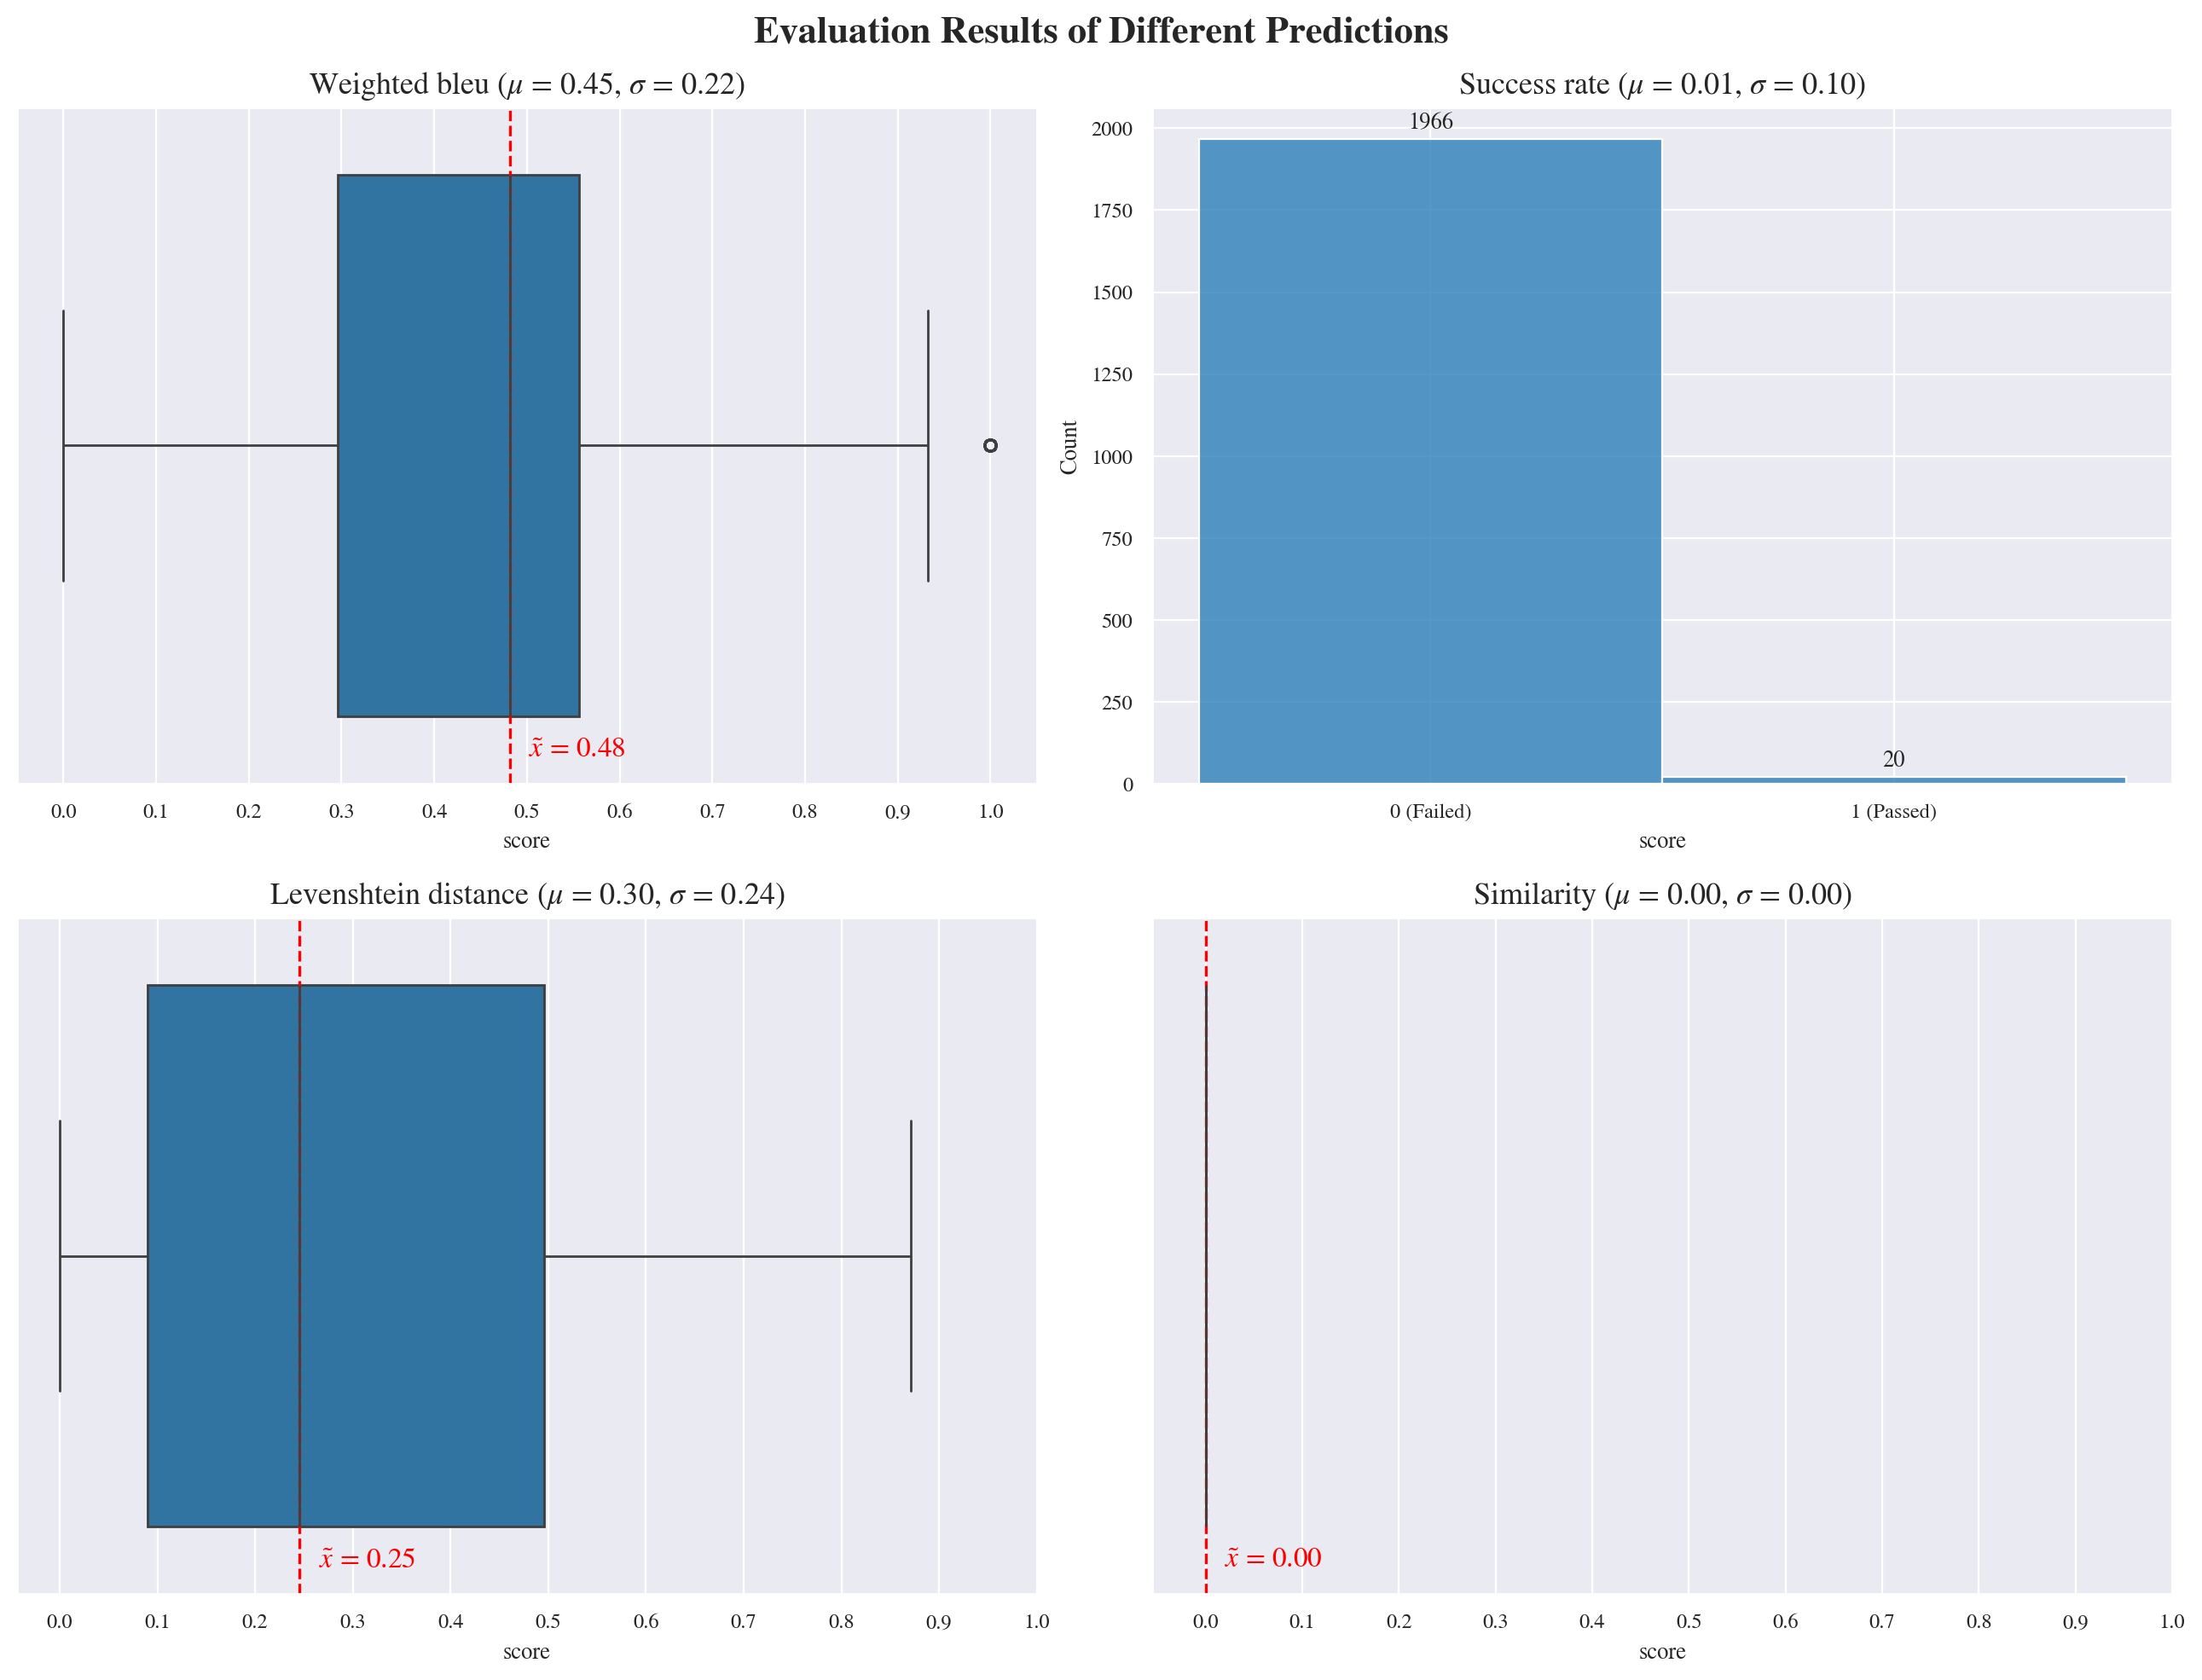

In [22]:
# Display evaluation results in a boxplot
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
for i, metric in enumerate(['weighted bleu', 'success rate', 'levenshtein distance', 'similarity']):
    if metric == 'success rate':
        sns.histplot(data=results, x=metric, ax=axes[i//2, i%2], bins=2, discrete=True)
        # Set xtick labels to '0 (Failed)' and '1 (Passed)'
        axes[i//2, i%2].set_xticks([0, 1])
        axes[i//2, i%2].set_xticklabels(['0 (Failed)', '1 (Passed)'])
        # Add numbers
        for p in axes[i//2, i%2].patches:
            axes[i//2, i%2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 7), textcoords = 'offset points')
    else:
        sns.boxplot(data=results, x=metric, ax=axes[i//2, i%2])
        # Add xticks from 0 to 1 in steps of 0.1
        axes[i//2, i%2].set_xticks([i/10 for i in range(11)])
        # Add median line
        axes[i//2, i%2].axvline(results[metric].median(), color='red', linestyle='--')
        axes[i//2, i%2].text(results[metric].median()+0.02, 0.46, r'$\tilde{x}$' + f' = {results[metric].median():.2f}', color='red', fontsize=12)

    axes[i//2, i%2].set_xlabel("score")
    axes[i//2, i%2].set_title(f'{metric.capitalize().replace("_", " ")}' + r' ($\mu$ = {:.2f}, $\sigma$ = {:.2f})'.format(results[metric].mean(), results[metric].std()), fontsize=13)

plt.suptitle('Evaluation Results of Different Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# References
[1]
```bibtex
@INPROCEEDINGS{Papineni02bleu:a,
    author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu},
    title = {BLEU: a Method for Automatic Evaluation of Machine Translation},
    booktitle = {},
    year = {2002},
    pages = {311--318}
}
```
[2]
```bibtex
@inproceedings{lin-och-2004-orange,
    title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation",
    author = "Lin, Chin-Yew  and
      Och, Franz Josef",
    booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics",
    month = "aug 23{--}aug 27",
    year = "2004",
    address = "Geneva, Switzerland",
    publisher = "COLING",
    url = "https://www.aclweb.org/anthology/C04-1072",
    pages = "501--507",
}
```
